In [1]:
#Import necessary packages
import psycopg2
import sys  
sys.path.append('..')

import numpy as np
import pandas as pd

from config import REDSHIFT_CONFIG
from src.features import *
from src.utils import *
from src.validation import *

reload(sys)
sys.setdefaultencoding('utf8')

from src.exploration import *

In [2]:
# Establish a connection to the redshift database
conn = create_rs_conn(config=REDSHIFT_CONFIG)
cur = conn.cursor()

In [21]:
#Increase the number of columns displayed with Pandas
pd.set_option('display.max_columns', 500)

In [29]:
from datetime import date

class Pitcher:
    '''Master class to contain all info/methods related to a pitcher's pitch data'''
    
    def __init__(self, pitcher_id, redshift_cursor, table = None):
        '''Stores:
            -a database cursor (self.cur)
            -pitcher ID (self.pitcher_id)
            -all pitcher data (self.data) from 'table' (all_pitch_data by default)
        '''
        
        #Store the pitcher's id
        self.pitcher_id = pitcher_id
        
        #Using a passed-in cursor instead of creating it here, so we don't have to open new connection
        #for each pitcher we create
        self.cur = redshift_cursor
        
        #Use exception handling in case we get a shutdown of the connection
        try:
            #Choose which table to pull data from
            if table is None:
                self.data = get_pitcher_df_for_modeling(self.cur, 
                                                        pitcher_id = pitcher_id, 
                                                        date_subsetting = False)
            else:
                self.data = get_pitcher_df_for_modeling(self.cur, 
                                                        pitcher_id = pitcher_id, 
                                                        date_subsetting = False,
                                                        table = table)
        except:
            # Re-establish a connection to the redshift database
            conn = create_rs_conn(config=REDSHIFT_CONFIG)
            self.cur = conn.cursor()
            
            #Choose which table to pull data from
            if table is None:
                self.data = get_pitcher_df_for_modeling(self.cur, 
                                                        pitcher_id = pitcher_id,
                                                        date_subsetting = False)
            else:
                self.data = get_pitcher_df_for_modeling(self.cur, 
                                                        pitcher_id = pitcher_id, 
                                                        date_subsetting = False,
                                                        table = table)
        
        #Get the pitcher's name
        self.cur.execute('''select p_first_name, p_last_name
                    from all_pitch_data
                    where pitcher = %d
                    limit 1''' % self.pitcher_id)
        self.name = " ".join(self.cur.fetchall()[0])
        
        #initiate a list that keeps track of methods called on the object (record-keeping)
        self.method_history = []    
            
    def find_optimal_date_splits(self):
        ''' '''
        self.method_history.append("split_test_train")
        
    def subset_data_by_date(self, max_date = None, min_date = '2008-01-01'):
        '''Subsets self.data based on max and min dates'''
        
        #Get a max_date if one not given
        if max_date is None:
            self.max_date = date.today().strftime('%Y-%m-%d')
        else:
            self.max_date = max_date
        
        #Store the minimum date
        self.min_date = min_date
        
        #Subset the data
        self.data = self.data[(self.data['date'] <= self.max_date) & (self.data['date'] >= self.min_date)]
        
        #Indicate that the method has been called
        self.method_history.append('subset_by_date')
        
    def subset_data_by_columns(self, cols):
        '''self.data is subset to only include "cols"'''
        self.modeling_dict['train_data'] = self.modeling_dict['train_data'][cols]
        self.modeling_dict['test_data'] = self.modeling_dict['test_data'][cols]
        self.method_history.append("subset_by_columns")
    
    def split_test_train(self, quantile_split = 0.9, date_override = None):
        '''Splits self.data into testing and train data, creating a new dictionary containing all the
        test/train data and targets'''
        
        #Get the date on which to split test/train
        if date_override is None:
            split_date = str(self.data['date'].quantile(quantile_split))[:10]
            
        else:
            split_date = date_override
        
        #split the data and return a dictionary with test/train data/targets
        self.modeling_dict = split_test_train(self.data, split_date)
        
        #Log the transaction
        self.method_history.append("split_test_train_" + split_date)
        
        #Store the baseline accuracy
        self.baseline_accuracy = naive_accuracy(self.modeling_dict)
        
    def pitch_type_by_year(self):
        '''returns a pandas dataframe getting the count of the pitch types by year'''
        return get_pitch_types_by_year(self.data, use_gameday = False)
    
    def run_classifiers(self):
        '''runs four different classifiers and tries to ensemble them'''
        
        classifier_dict = run_all_classifiers(self.modeling_dict)
        all_predictions_dict = collect_classifier_predictions2(self.modeling_dict, classifier_dict)
        best_classifiers = choose_best_ensemble(all_predictions_dict, self.modeling_dict)
        
        #Handle cases where there's a single classifier chosen
        if type(best_classifiers['classifier_combination']) == str:
            
            single_class = best_classifiers['classifier_combination']
            self.classifiers = {single_class: classifier_dict[single_class]}
            
        else:
            
            self.classifiers = dict((k, classifier_dict[k]) for k in best_classifiers['classifier_combination'])
            
        self.best_acc = best_classifiers['best_acc']
        self.acc_over_most_common = self.best_acc - self.baseline_accuracy
        print 'classifiers used:', self.classifiers.keys()
        print 'best accuracy:', self.best_acc
        print "Accuracy above guessing most common:", self.acc_over_most_common
        
        #Log it
        self.method_history.append('ran_classifiers')
    
    def predict(self, new_data):
        '''runs best ensemble'''
        pred_dict = {}
        
        #Make predictions based for each classifier
        for classifier in self.classifiers.keys():

            # Make predictions on new data
            pred_dict[classifier] = self.classifier[classifier].predict(new_data)
            
        #Vote based on the predictions
        return ensemble_voting(pred_dict)
    
    def prepare_for_pickle(self):
        '''Delete all the data (before serializing the object)'''
        
        del(self.data)
        del(self.modeling_dict)
        del(self.cur)
        self.method_history.append('deleted all data and cursor')
        
    def del_cur(self):
        del(self.cur)

In [4]:
#Load the pitcher dict with 5 saved randomly sampled pitchers
import pickle
with open('pitcher_samp5.pickle', 'rb') as f:
    pitcher_dict = pickle.load(f)

In [7]:
?RandomForestClassifier

In [6]:
import sklearn
sklearn.__version__

'0.16.1'

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
def run_classifier2(classifier, data_dict):
    """Given a classifier and a data dictionary containing 'train_data' and 'test_data' (as pandas DFs),
    This runs the classifier and outputs the accuracy of the classifier on the test data."""
    
    # Fit a model on all the data and features
    classifier.fit(data_dict['train_data'], data_dict['train_targets'])

    # Make predictions on dev data
    dev_predictions = classifier.predict(data_dict['test_data'])
    
    # Return the dev performance score.
    return accuracy_score(data_dict['test_targets'], dev_predictions), dev_predictions

In [13]:
acc_compare = {}

#Run a random forest over each pitcher with and without class re-weighting
for pitcher in pitcher_dict.keys():
    acc_compare[pitcher] = {}
    basic_acc, preds = run_classifier2(RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350),
                              data_dict = pitcher_dict[pitcher].modeling_dict)
    acc_compare[pitcher]['baseline'] = pitcher_dict[pitcher].baseline_accuracy
    acc_compare[pitcher]['rf'] = basic_acc
    acc_compare[pitcher]['rf_over_baseline'] = basic_acc - acc_compare[pitcher]['baseline']
    acc_compare[pitcher]['rf_confusion_matrix'] = confusion_matrix(pitcher_dict[pitcher].modeling_dict['test_targets'],
                                                                   preds)

    print 'baseline acc:', acc_compare[pitcher]['baseline']
    print 'rf_over_baseline:', acc_compare[pitcher]['rf_over_baseline']
    print 'confusion matrix:', acc_compare[pitcher]['rf_confusion_matrix']
    
    #Run the random forest and weight classes inversely proportional to their counts
    weighted_acc = run_classifier(RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350,
                                                     class_weight = 'auto'),
                                 data_dict = pitcher_dict[pitcher].modeling_dict)
    acc_compare[pitcher]['weighted'] = weighted_acc
    acc_compare[pitcher]['weighted_over_rf'] = weighted_acc - acc_compare[pitcher]['rf']
    print 'weighted acc:', acc_compare[pitcher]['weighted']
    print 'weighted over rf:', acc_compare[pitcher]['weighted_over_rf']
    
    #Let the user decide the class re-weighting based on the current weights and the confusion matrix

### try this for 10 randomly sample pitchers 

In [62]:
with open('pitcher_samp10.pickle', 'rb') as f:
    pitcher_dict2 = pickle.load(f)

In [68]:
acc_compare = {}

#Run a random forest over each pitcher with and without class re-weighting
for pitcher in pitcher_dict2.keys():
    acc_compare[pitcher] = {}
    basic_acc, preds = run_classifier2(RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350,
                                                             random_state = 35),
                              data_dict = pitcher_dict2[pitcher].modeling_dict)
    acc_compare[pitcher]['baseline'] = pitcher_dict2[pitcher].baseline_accuracy
    acc_compare[pitcher]['rf'] = basic_acc
    acc_compare[pitcher]['rf_over_baseline'] = basic_acc - acc_compare[pitcher]['baseline']
    acc_compare[pitcher]['rf_confusion_matrix'] = confusion_matrix(pitcher_dict2[pitcher].modeling_dict['test_targets'],
                                                                   preds)

    print 'baseline acc:', acc_compare[pitcher]['baseline']
    print 'rf_over_baseline:', acc_compare[pitcher]['rf_over_baseline']
    print 'confusion matrix:', acc_compare[pitcher]['rf_confusion_matrix']
    
    #Run the random forest and weight classes inversely proportional to their counts
    weighted_acc = run_classifier(RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350,
                                                     class_weight = 'auto',
                                                        random_state = 35),
                                 data_dict = pitcher_dict2[pitcher].modeling_dict)
    acc_compare[pitcher]['weighted'] = weighted_acc
    acc_compare[pitcher]['weighted_over_rf'] = weighted_acc - acc_compare[pitcher]['rf']
    print 'weighted acc:', acc_compare[pitcher]['weighted']
    print 'weighted over rf:', acc_compare[pitcher]['weighted_over_rf']
    
    #Let the user decide the class re-weighting based on the current weights and the confusion matrix

In [71]:
acc_compare

{445926: {'baseline': 0.693,
  'rf': 0.69306930693069302,
  'rf_confusion_matrix': array([[630,   0],
         [279,   0]]),
  'rf_over_baseline': 6.9306930693069368e-05,
  'weighted': 0.49834983498349833,
  'weighted_over_rf': -0.19471947194719469},
 446372: {'baseline': 0.528,
  'rf': 0.57172342621259031,
  'rf_confusion_matrix': array([[232, 225],
         [190, 322]]),
  'rf_over_baseline': 0.043723426212590288,
  'weighted': 0.58101135190918474,
  'weighted_over_rf': 0.0092879256965944235},
 468396: {'baseline': 0.666,
  'rf': 0.67519181585677746,
  'rf_confusion_matrix': array([[504,  17],
         [237,  24]]),
  'rf_over_baseline': 0.0091918158567774189,
  'weighted': 0.60102301790281332,
  'weighted_over_rf': -0.074168797953964138},
 475115: {'baseline': 0.514,
  'rf': 0.57336108220603543,
  'rf_confusion_matrix': array([[396,  98],
         [312, 155]]),
  'rf_over_baseline': 0.05936108220603542,
  'weighted': 0.53173777315296566,
  'weighted_over_rf': -0.041623309053069768},

In [76]:
def acc_stats(acc_compare):
    counter = 0
    for pitcher in acc_compare.keys():
        if acc_compare[pitcher]['weighted_over_rf'] > .015:
            counter += 1
            print pitcher, acc_compare[pitcher]['weighted_over_rf']
    return counter

In [77]:
acc_stats(acc_compare)

1

### See if it helps to do some column subsetting 

In [75]:
# Create a list of the columns that we're interested in using as features
cols_of_interest = ([u'b', u's', u'on_1b', u'on_2b', u'on_3b', u'o',
                     u'home_wins',u'home_loss', u'away_wins', u'away_loss',
                     u'stand_L', u'Not_Fastball_pb_prior', u'Not_Fastball_pbs_prior', 
                     u'Fastball_pb_prior', u'Fastball_pbs_prior', u'Not_Fastball_pc_prior', 
                     u'Not_Fastball_pcs_prior', u'Fastball_pc_prior', u'Fastball_pcs_prior', 
                     u'Not_Fastball_pg_prior', u'Not_Fastball_pgs_prior', 
                     u'Fastball_pg_prior', u'Fastball_pgs_prior', u'last_pitch_type_Fastball', 
                     u'last_pitch_type_Not_Fastball',u'last_pitch_type_not_available', 
                     u'second_last_pitch_type_Fastball',u'second_last_pitch_type_Not_Fastball',
                     u'second_last_pitch_type_not_available', u'third_last_pitch_type_Fastball',
                     u'third_last_pitch_type_Not_Fastball', u'third_last_pitch_type_not_available', 
                     u'prev_pitches_mean_start_speed', u'prev_pitches_mean_end_speed',
                     u'prev_pitches_mean_break_y', u'prev_pitches_mean_break_angle',
                     u'prev_pitches_mean_break_length', u'ingame_pitch_count', u'cur_season', u'season_pitch_count'])

In [78]:
acc_compare = {}

#Run a random forest over each pitcher with and without class re-weighting
for pitcher in pitcher_dict2.keys():
    acc_compare[pitcher] = {}
    pitcher_dict2[pitcher].subset_data_by_columns(cols_of_interest)
    basic_acc, preds = run_classifier2(RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350,
                                                             random_state = 35),
                              data_dict = pitcher_dict2[pitcher].modeling_dict)
    acc_compare[pitcher]['baseline'] = pitcher_dict2[pitcher].baseline_accuracy
    acc_compare[pitcher]['rf'] = basic_acc
    acc_compare[pitcher]['rf_over_baseline'] = basic_acc - acc_compare[pitcher]['baseline']
    acc_compare[pitcher]['rf_confusion_matrix'] = confusion_matrix(pitcher_dict2[pitcher].modeling_dict['test_targets'],
                                                                   preds)

    print 'baseline acc:', acc_compare[pitcher]['baseline']
    print 'rf_over_baseline:', acc_compare[pitcher]['rf_over_baseline']
    print 'confusion matrix:', acc_compare[pitcher]['rf_confusion_matrix']
    
    #Run the random forest and weight classes inversely proportional to their counts
    weighted_acc = run_classifier(RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350,
                                                     class_weight = 'auto',
                                                        random_state = 35),
                                 data_dict = pitcher_dict2[pitcher].modeling_dict)
    acc_compare[pitcher]['weighted'] = weighted_acc
    acc_compare[pitcher]['weighted_over_rf'] = weighted_acc - acc_compare[pitcher]['rf']
    print 'weighted acc:', acc_compare[pitcher]['weighted']
    print 'weighted over rf:', acc_compare[pitcher]['weighted_over_rf']

In [79]:
acc_compare

{445926: {'baseline': 0.693,
  'rf': 0.69306930693069302,
  'rf_confusion_matrix': array([[630,   0],
         [279,   0]]),
  'rf_over_baseline': 6.9306930693069368e-05,
  'weighted': 0.49834983498349833,
  'weighted_over_rf': -0.19471947194719469},
 446372: {'baseline': 0.528,
  'rf': 0.57172342621259031,
  'rf_confusion_matrix': array([[232, 225],
         [190, 322]]),
  'rf_over_baseline': 0.043723426212590288,
  'weighted': 0.58101135190918474,
  'weighted_over_rf': 0.0092879256965944235},
 468396: {'baseline': 0.666,
  'rf': 0.67519181585677746,
  'rf_confusion_matrix': array([[504,  17],
         [237,  24]]),
  'rf_over_baseline': 0.0091918158567774189,
  'weighted': 0.60102301790281332,
  'weighted_over_rf': -0.074168797953964138},
 475115: {'baseline': 0.514,
  'rf': 0.57336108220603543,
  'rf_confusion_matrix': array([[396,  98],
         [312, 155]]),
  'rf_over_baseline': 0.05936108220603542,
  'weighted': 0.53173777315296566,
  'weighted_over_rf': -0.041623309053069768},

In [80]:
#Getting rid of those columns doesn't help
acc_stats(acc_compare)

1

In [28]:
pitcher_dict2[446372].method_history

['split_test_train_2015-06-03']

## Try sample re-weighting based on recency of the data point 

In [82]:
tester = pitcher_dict2[446372].modeling_dict
tester2 = pitcher_dict2[446372].data

In [83]:
get_pitch_types_by_year(tester2, use_gameday = False)

pitch_type,Fastball,Not_Fastball
2011,40,48
2012,472,610
2013,1215,1072
2014,1828,1667
2015,1031,1075


In [84]:
split_date = pitcher_dict2[446372].method_history[0][17:]

In [85]:
all_dates = tester2['date'][tester2['date'] < split_date]

In [86]:
days = ((max(all_dates) - all_dates).values / 86400000000000).astype(int)

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

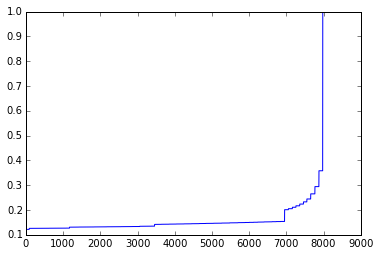

In [52]:
plt.plot(1 / (np.log(days + 1) + 1))

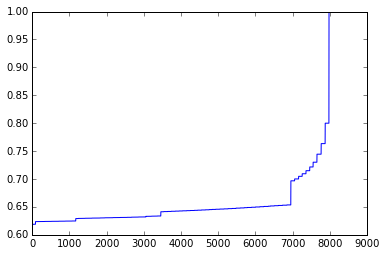

In [58]:
plt.plot(1 / (np.log10(np.log10(days + 1) + 1) + 1))

In [59]:
def double_log_day_diff(day_diff):
    
    return 1 / (np.log10(np.log10(day_diff + 1) + 1) + 1)

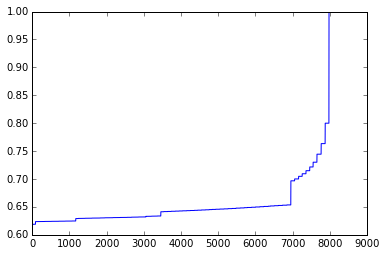

In [60]:
plt.plot(double_log_day_diff(days))

In [61]:
double_log_day_diff(days)

array([ 0.61861173,  0.61861173,  0.61861173, ...,  1.        ,
        1.        ,  1.        ])

In [81]:
#Try random forest with sample weighting
testClass = RandomForestClassifier(max_depth=3,
                       min_samples_leaf = 7,
                       min_samples_split = 6,
                       n_estimators = 350,
                       random_state = 35)

In [90]:
testClass.fit(tester['train_data'], tester['train_targets'], sample_weight = double_log_day_diff(days))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=7, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=1,
            oob_score=False, random_state=35, verbose=0, warm_start=False)

In [93]:
accuracy_score(tester['test_targets'], testClass.predict(tester['test_data'])) - pitcher_dict2[446372].baseline_accuracy

0.047851393188854452

In [92]:
accuracy_score(tester['test_targets'], testClass.predict(tester['test_data']))

0.57585139318885448

In [104]:
#Try it across all the pitchers
acc_compare = {}
for pitcher in pitcher_dict2.keys():
    acc_compare[pitcher] = {}
    basic_acc, preds = run_classifier2(RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350,
                                                             random_state = 35),
                              data_dict = pitcher_dict2[pitcher].modeling_dict)
    acc_compare[pitcher]['baseline'] = pitcher_dict2[pitcher].baseline_accuracy
    acc_compare[pitcher]['rf'] = basic_acc
    acc_compare[pitcher]['rf_over_baseline'] = basic_acc - acc_compare[pitcher]['baseline']
    acc_compare[pitcher]['rf_confusion_matrix'] = confusion_matrix(pitcher_dict2[pitcher].modeling_dict['test_targets'],
                                                                   preds)

    print 'baseline acc:', acc_compare[pitcher]['baseline']
    print 'rf_over_baseline:', acc_compare[pitcher]['rf_over_baseline']
    print 'confusion matrix:', acc_compare[pitcher]['rf_confusion_matrix']
    
    #Run the random forest and weight classes inversely proportional to their counts
    split_date = pitcher_dict2[pitcher].method_history[0][17:]
    all_dates = pitcher_dict2[pitcher].data['date'][pitcher_dict2[pitcher].data['date'] < split_date]
    print all_dates.head()
    print all_dates.tail()
    days = ((max(all_dates) - all_dates).values / 86400000000000).astype(int)
    weights = double_log_day_diff(days)
    print weights[:5]
    print weights[-5:]
    
    #Make sure the data is aligned properly
    print 'data match:' all(pitcher_dict2[pitcher].data['pitch_type'].head() == pitcher_dict2[pitcher].modeling_dict['train_targets'].head())
    
    #Run classifier with sample weights
    classifier = RandomForestClassifier(max_depth=3,
                                          min_samples_leaf = 7,
                                          min_samples_split = 6,
                                          n_estimators = 350,
                                          random_state = 35)
    classifier.fit(pitcher_dict2[pitcher].modeling_dict['train_data'],
                   pitcher_dict2[pitcher].modeling_dict['train_targets'],
                   sample_weight = weights)
    predictions = classifier.predict(pitcher_dict2[pitcher].modeling_dict['test_data'])
    weighted_acc = accuracy_score(pitcher_dict2[pitcher].modeling_dict['test_targets'], predictions)
    
    #Store and print the results
    acc_compare[pitcher]['weighted'] = weighted_acc
    acc_compare[pitcher]['weighted_over_rf'] = weighted_acc - acc_compare[pitcher]['rf']
    print 'weighted acc:', acc_compare[pitcher]['weighted']
    print 'weighted over rf:', acc_compare[pitcher]['weighted_over_rf']

In [105]:
acc_compare

{445926: {'baseline': 0.693,
  'rf': 0.69306930693069302,
  'rf_confusion_matrix': array([[630,   0],
         [279,   0]]),
  'rf_over_baseline': 6.9306930693069368e-05,
  'weighted': 0.69306930693069302,
  'weighted_over_rf': 0.0},
 446372: {'baseline': 0.528,
  'rf': 0.57172342621259031,
  'rf_confusion_matrix': array([[232, 225],
         [190, 322]]),
  'rf_over_baseline': 0.043723426212590288,
  'weighted': 0.57585139318885448,
  'weighted_over_rf': 0.0041279669762641635},
 468396: {'baseline': 0.666,
  'rf': 0.67519181585677746,
  'rf_confusion_matrix': array([[504,  17],
         [237,  24]]),
  'rf_over_baseline': 0.0091918158567774189,
  'weighted': 0.67647058823529416,
  'weighted_over_rf': 0.0012787723785167016},
 475115: {'baseline': 0.514,
  'rf': 0.57336108220603543,
  'rf_confusion_matrix': array([[396,  98],
         [312, 155]]),
  'rf_over_baseline': 0.05936108220603542,
  'weighted': 0.57336108220603543,
  'weighted_over_rf': 0.0},
 518420: {'baseline': 0.504,
  'rf

In [106]:
#No help with the class re-weighting
acc_stats(acc_compare)

0

## See how normalizing continuous variables affects accuracy 

In [107]:
from sklearn.preprocessing import StandardScaler

In [117]:
tester['train_data'].head()

,b,s,on_1b,on_2b,on_3b,o,home_wins,home_loss,away_wins,away_loss,stand_L,Not_Fastball_pb_prior,Not_Fastball_pbs_prior,Fastball_pb_prior,Fastball_pbs_prior,Not_Fastball_pc_prior,Not_Fastball_pcs_prior,Fastball_pc_prior,Fastball_pcs_prior,Not_Fastball_pg_prior,Not_Fastball_pgs_prior,Fastball_pg_prior,Fastball_pgs_prior,last_pitch_type_Fastball,last_pitch_type_Not_Fastball,last_pitch_type_not_available,second_last_pitch_type_Fastball,second_last_pitch_type_Not_Fastball,second_last_pitch_type_not_available,third_last_pitch_type_Fastball,third_last_pitch_type_Not_Fastball,third_last_pitch_type_not_available,prev_pitches_mean_start_speed,prev_pitches_mean_end_speed,prev_pitches_mean_break_y,prev_pitches_mean_break_angle,prev_pitches_mean_break_length,ingame_pitch_count,cur_season,season_pitch_count
15500,0,0,1,1,0,2,68,66,61,76,1,0.000000,1.000000,0.000000,0.000000,1.0,1.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,1,88.000000,80.900000,23.8,2.6,7.000000,1,0,1
15502,0,1,1,1,0,2,68,66,61,76,1,0.000000,0.500000,1.000000,0.600000,0.0,0.500000,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,1,0,0,0,1,0,0,0,1,89.500000,82.300000,23.8,12.6,6.300000,2,0,2
15724,0,2,1,1,0,2,68,66,61,76,1,0.500000,0.633333,0.500000,0.366667,0.0,0.666667,0.0,0.333333,0.666667,0.666667,0.333333,0.333333,0,1,0,1,0,0,0,1,0,87.033333,80.100000,23.8,14.0,6.600000,3,0,3
15726,0,3,1,1,0,2,68,66,61,76,1,0.333333,0.466667,0.666667,0.555556,0.0,0.500000,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,1,0,0,0,1,0,1,0,0,87.533333,80.433333,23.8,12.4,6.600000,4,0,4
5259,0,0,1,1,0,2,68,66,61,76,1,0.000000,0.400000,0.000000,0.600000,0.5,0.420000,0.5,0.580000,0.400000,0.400000,0.600000,0.600000,1,0,0,1,0,0,0,1,0,88.333333,81.033333,23.8,14.0,6.233333,5,0,5


In [111]:
tester['train_data'].head().values

array([[  0.        ,   0.        ,   1.        ,   1.        ,
          0.        ,   2.        ,  68.        ,  66.        ,
         61.        ,  76.        ,   1.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   1.        ,
          1.        ,   0.        ,   0.        ,   1.        ,
          1.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   1.        ,
         88.        ,  80.9       ,  23.8       ,   2.6       ,
          7.        ,   1.        ,   0.        ,   1.        ],
       [  0.        ,   1.        ,   1.        ,   1.        ,
          0.        ,   2.        ,  68.        ,  66.        ,
         61.        ,  76.        ,   1.        ,   0.        ,
          0.5       ,   1.        ,   0.6       ,   0.        ,
          0.5       ,   0.        ,   0.5       ,   0.5       ,
          0.5       ,   0.5       ,   0

In [118]:
?StandardScaler

In [116]:
StandardScaler().fit_transform(tester['train_data'].head())

array([[ 0.        , -1.02899151,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.79056942,  1.86953086, -1.1147408 , -1.85305938,
         1.75      ,  1.84391561, -0.5       , -1.84391561,  1.82864332,
         1.82864332, -1.82864332, -1.82864332, -1.22474487,  1.22474487,
         0.        , -0.81649658, -0.81649658,  2.        , -0.5       ,
        -0.81649658,  1.22474487, -0.0958743 , -0.0709997 ,  0.        ,
        -1.97544273,  1.66598626, -1.41421356,  0.        , -1.41421356],
       [ 0.        , -0.17149859,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.79056942, -0.46738271,  1.45773797,  0.76644864,
        -0.75      , -0.56538179, -0.5       ,  0.56538179, -0.53598166,
        -0.53598166,  0.53598166,  0.53598166,  0.81649658, -0.81649658,
         0.        , -0.81649658,  1.22474487, -0.

In [114]:
?StandardScaler.fit_transform